# Customer Segmentation Analysis: User Behavior

This notebook performs clustering analysis on e-commerce customer data to identify distinct customer segments based on purchase patterns, browsing behavior, and discount usage.

## Setup and Library Imports

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import os
import warnings
from sklearn.model_selection import train_test_split
import time
from mpl_toolkits.mplot3d import Axes3D
warnings.filterwarnings("ignore")

### Output directory and Plotting

In [2]:
output_dir = "output" # Output directory
os.makedirs(output_dir, exist_ok=True)

# Plotting style
plt.style.use('ggplot')
sns.set_context("notebook", font_scale=1.2)
plt.rcParams['figure.figsize'] = [12, 8]

## Data Loading and Initial Exploration

In [3]:
# Load the dataset
df = pd.read_csv('data2.csv')

# Display basic information
print(f"Dataset shape: {df.shape}")
print("\nFirst few rows:")
print(df.head())

# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

# Basic statistics
print("\nBasic statistics:")
print(df.describe())

Dataset shape: (999, 6)

First few rows:
   total_purchases  avg_cart_value  total_time_spent  product_click  \
0              7.0          129.34             52.17           18.0   
1             22.0           24.18              9.19           15.0   
2              2.0           32.18             90.69           50.0   
3             25.0           26.85             11.22           16.0   
4              7.0          125.45             34.19           30.0   

   discount_counts customer_id  
0              0.0     CM00000  
1              7.0     CM00001  
2              2.0     CM00002  
3             10.0     CM00003  
4              3.0     CM00004  
Missing values per column:
total_purchases     20
avg_cart_value      20
total_time_spent     0
product_click       20
discount_counts      0
customer_id          0
dtype: int64

Basic statistics:
       total_purchases  avg_cart_value  total_time_spent  product_click  \
count       979.000000      979.000000        999.000000     9

## Data Preprocessing

In [4]:
# Identify columns
feature_cols = ['total_purchases', 'avg_cart_value', 'total_time_spent', 'product_click', 'discount_counts']

# Handle missing values (drop rows with missing values)
df_clean = df.dropna(subset=feature_cols)

# Reset index
df_clean = df_clean.reset_index(drop=True)
print(f"Dataset shape after removing rows with missing values: {df_clean.shape}")

# Verify data quality after cleaning
print("\nData quality after cleaning:")
print(f"Any missing values remaining: {df_clean[feature_cols].isnull().sum().sum() > 0}")

Dataset shape after removing rows with missing values: (979, 6)

Data quality after cleaning:
Any missing values remaining: False


### Feature Engineering

In [5]:
# Create ratio features
print("\nPerforming feature engineering...")
df_clean['price_per_purchase'] = df_clean['avg_cart_value'] / df_clean['total_purchases'].replace(0, np.nan)
df_clean['time_per_click'] = df_clean['total_time_spent'] / df_clean['product_click'].replace(0, np.nan)
df_clean['discount_per_purchase'] = df_clean['discount_counts'] / df_clean['total_purchases'].replace(0, np.nan)
df_clean['clicks_per_purchase'] = df_clean['product_click'] / df_clean['total_purchases'].replace(0, np.nan)

# Handle infinite values resulting from division by zero
df_clean.replace([np.inf, -np.inf], np.nan, inplace=True)
df_clean.fillna(0, inplace=True)

# Define the extended feature set including engineered features
extended_feature_cols = feature_cols + ['price_per_purchase', 'time_per_click',
                                       'discount_per_purchase', 'clicks_per_purchase']

# Output the engineered features
print("\nEngineered features:")
print(df_clean[['price_per_purchase', 'time_per_click', 'discount_per_purchase',
                'clicks_per_purchase']].describe())

# Check shape after feature engineering
print(f"df_clean shape: {df_clean.shape}")



Performing feature engineering...

Engineered features:
       price_per_purchase  time_per_click  discount_per_purchase  \
count          979.000000      979.000000             979.000000   
mean            10.016360        1.759312               0.337339   
std              9.215514        0.802848               0.293979   
min              0.000000        0.222000               0.000000   
25%              2.135394        1.246929               0.127717   
50%              8.856923        1.704167               0.285714   
75%             14.592727        2.160791               0.500000   
max             76.610000        7.485000               2.000000   

       clicks_per_purchase  
count           979.000000  
mean              5.129158  
std               6.871201  
min               0.000000  
25%               0.941176  
50%               2.000000  
75%               8.166667  
max              60.000000  
df_clean shape: (979, 10)


## Exploratory Data Analysis

### Feature Distributions

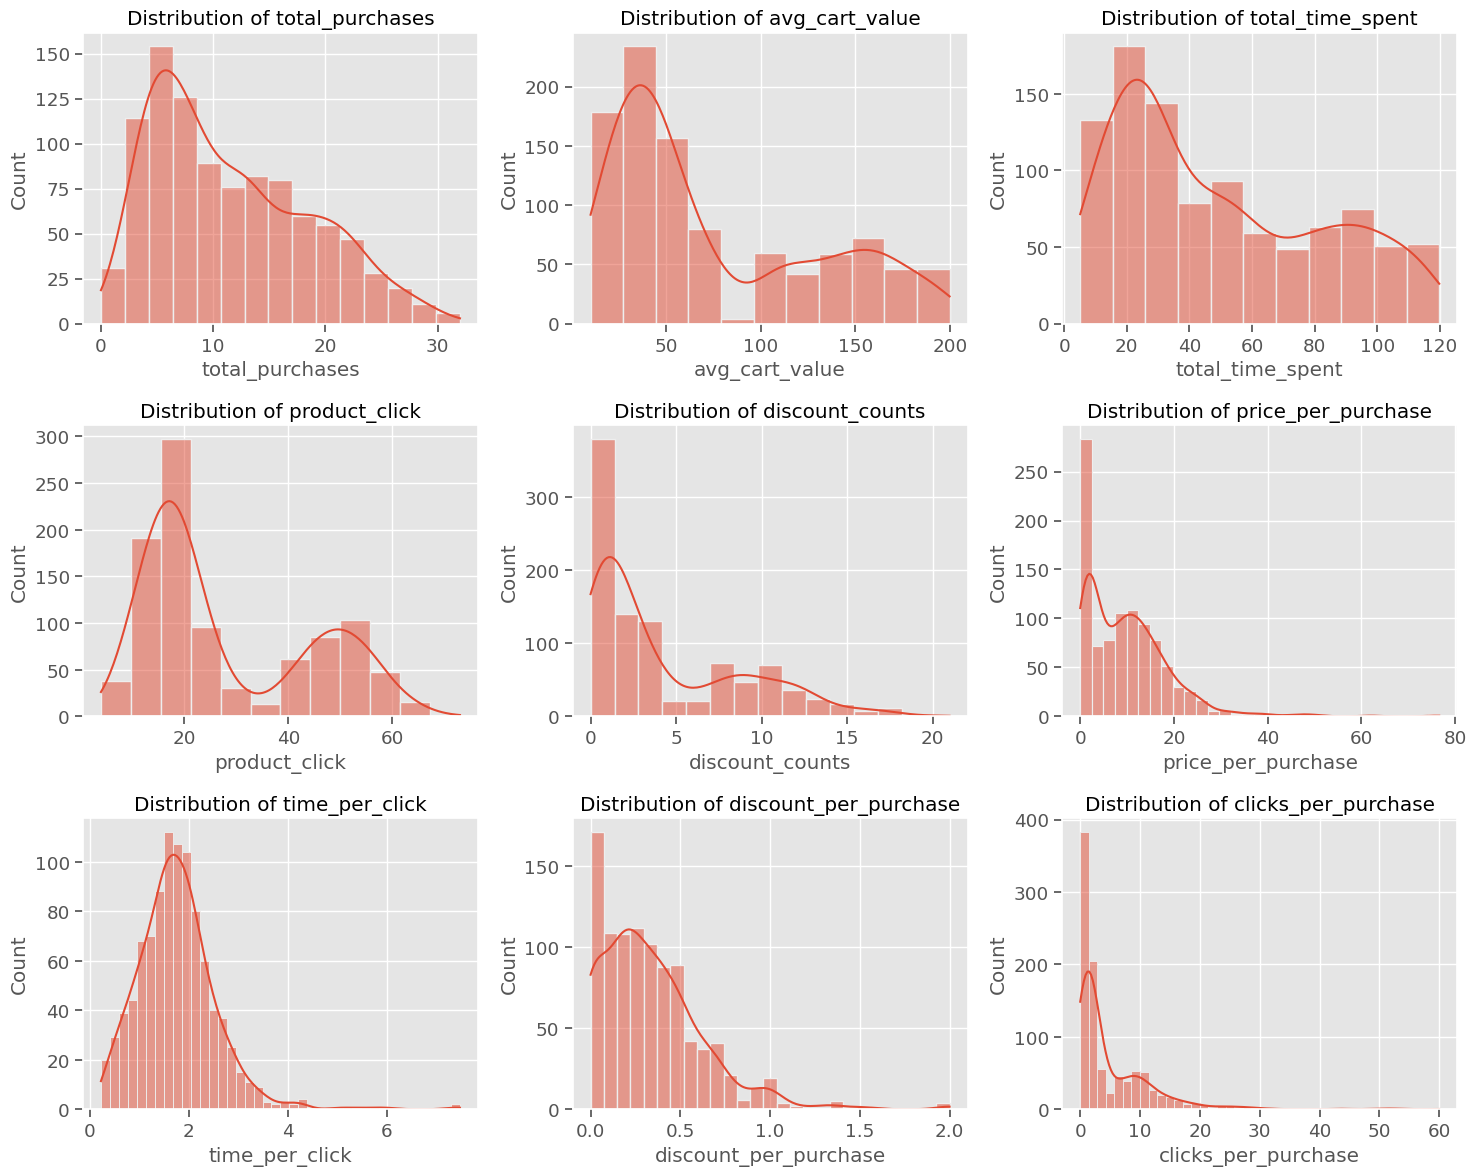

In [6]:
plt.figure(figsize=(15, 12))
for i, col in enumerate(extended_feature_cols, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df_clean[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.tight_layout()
plt.savefig(os.path.join(output_dir, "feature_distributions.png"))
plt.show()
plt.close()

### Outlier Detection

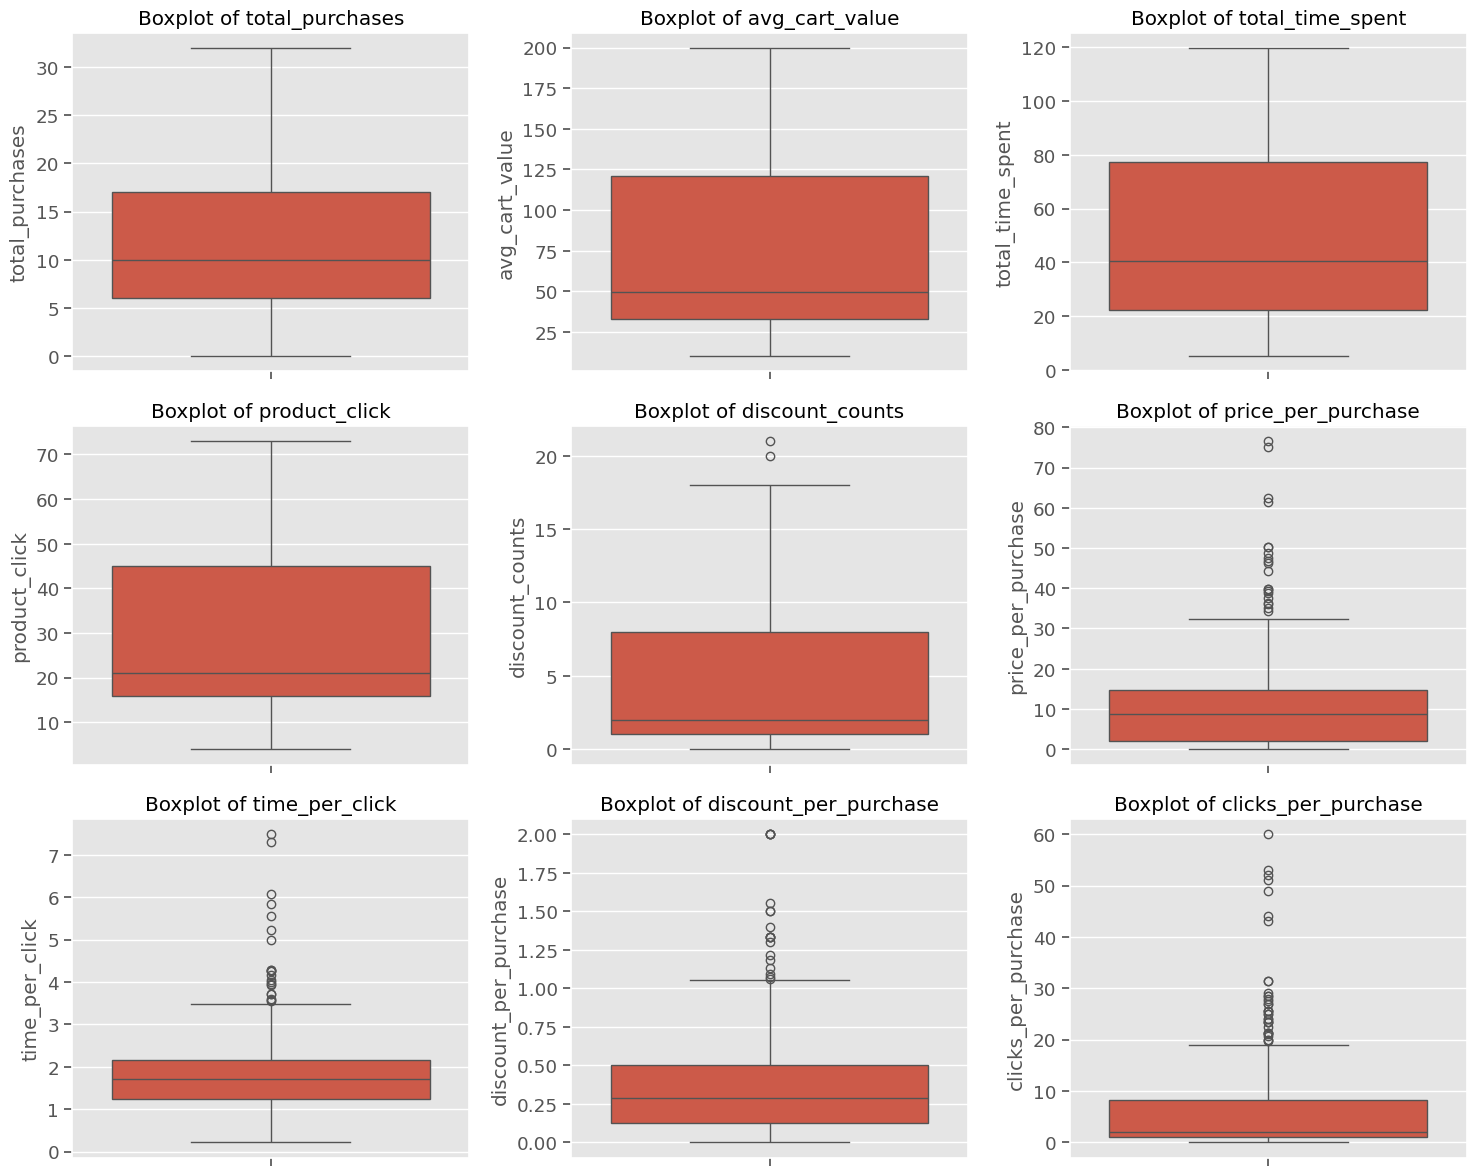

In [7]:
# Box plots to identify outliers
plt.figure(figsize=(15, 12))
for i, col in enumerate(extended_feature_cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=df_clean[col])
    plt.title(f'Boxplot of {col}')
    plt.tight_layout()
plt.savefig(os.path.join(output_dir, "feature_boxplots.png"))
plt.show()
plt.close()

### Feature Correlation Analysis

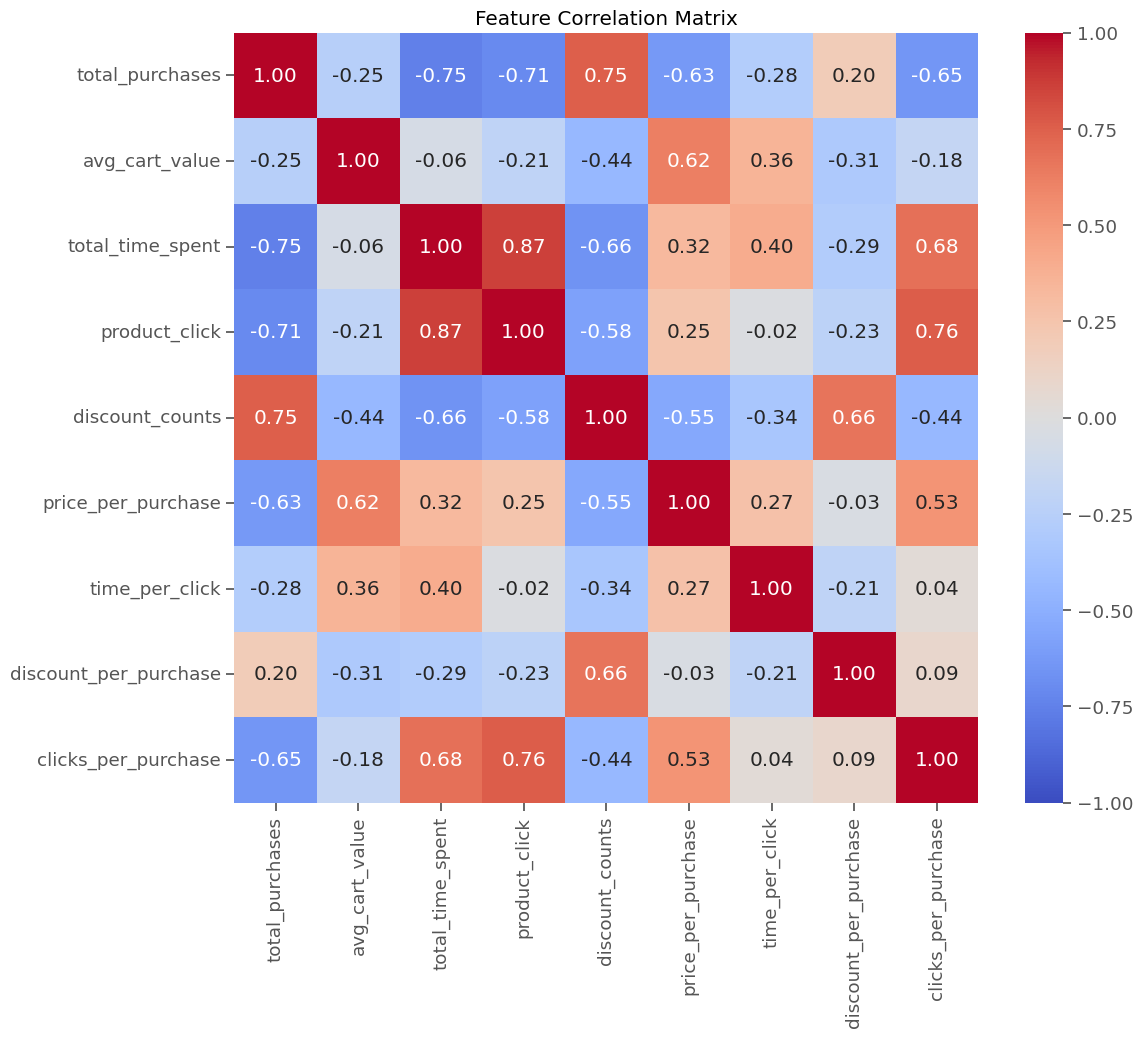

In [8]:
# Correlation matrix
plt.figure(figsize=(12, 10))
correlation = df_clean[extended_feature_cols].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.savefig(os.path.join(output_dir, "correlation_matrix.png"))
plt.show()
plt.close()

## Feature Scaling and Preparation for Clustering

In [9]:
# Extract features for clustering
X = df_clean[feature_cols].copy()

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Features scaled to zero mean and unit variance.")

# Scale the extended features for visualization
X_extended = df_clean[extended_feature_cols].copy()
X_extended_scaled = scaler.fit_transform(X_extended)

Features scaled to zero mean and unit variance.


## Determining the Optimal Number of Clusters

### Elbow Method

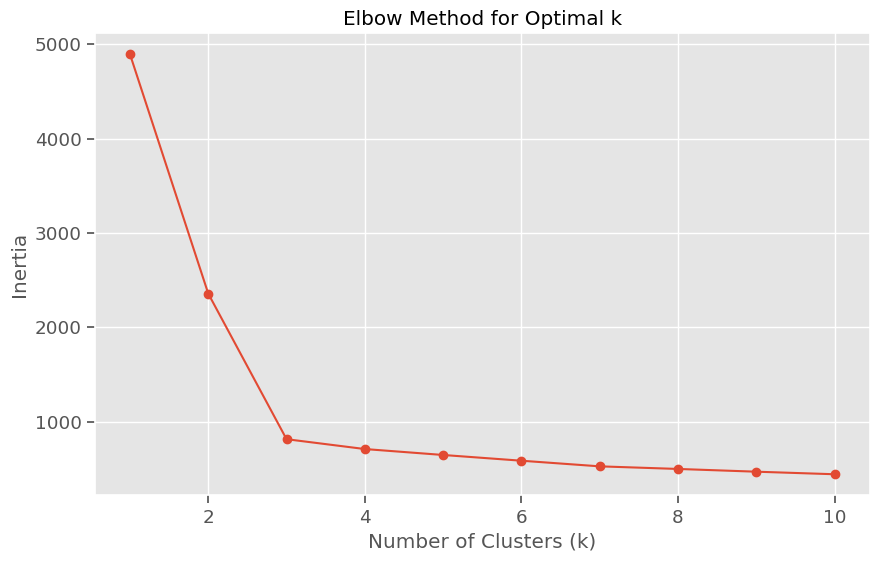

In [10]:
# Determine optimal number of clusters using Elbow Method
inertia = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.savefig(os.path.join(output_dir, "elbow_method.png"))
plt.show()
plt.close()

### Silhouette Analysis

For k=2, silhouette score: 0.497
For k=3, silhouette score: 0.626
For k=4, silhouette score: 0.512
For k=5, silhouette score: 0.378
For k=6, silhouette score: 0.372
For k=7, silhouette score: 0.245
For k=8, silhouette score: 0.233
For k=9, silhouette score: 0.223
For k=10, silhouette score: 0.223


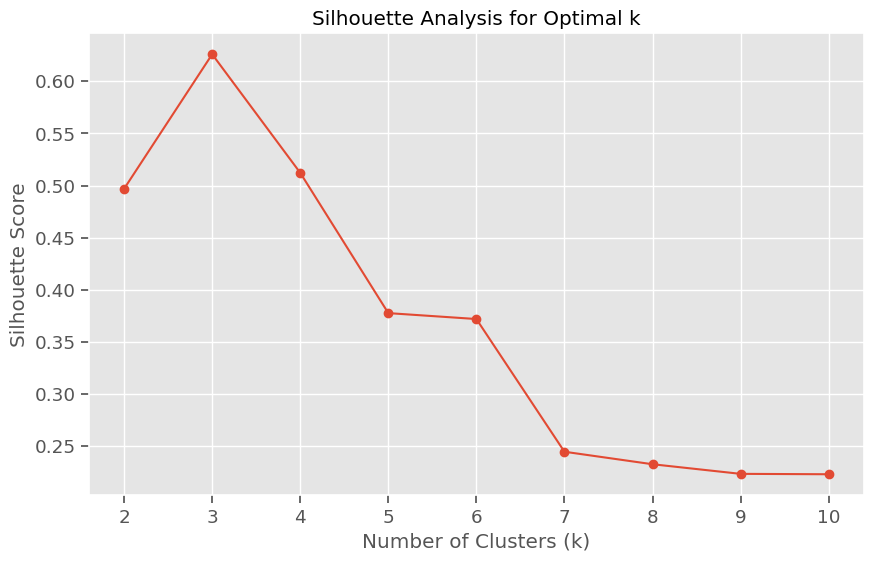

In [11]:
# Silhouette Analysis
silhouette_scores = []
for k in range(2, 11):  # Silhouette score needs at least 2 clusters
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"For k={k}, silhouette score: {silhouette_avg:.3f}")

plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for Optimal k')
plt.grid(True)
plt.savefig(os.path.join(output_dir, "silhouette_analysis.png"))
plt.show()
plt.close()

## Clustering Model Implementation and Evaluation

Implementing different clustering algorithms and evaluating their performance using various metrics.

###  Clustering Evaluation Function

In [12]:
# Function to evaluate clustering results
def evaluate_clustering(X, labels, algorithm_name):
    silhouette = silhouette_score(X, labels)
    davies_bouldin = davies_bouldin_score(X, labels)
    calinski_harabasz = calinski_harabasz_score(X, labels)

    print(f"{algorithm_name}:")
    print(f"  Silhouette Score: {silhouette:.3f} (higher is better)")
    print(f"  Davies-Bouldin Index: {davies_bouldin:.3f} (lower is better)")
    print(f"  Calinski-Harabasz Index: {calinski_harabasz:.3f} (higher is better)")

    return silhouette, davies_bouldin, calinski_harabasz

### K-Means Clustering

In [13]:
print("\nPerforming K-Means clustering (k=3)...")
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)
kmeans_eval = evaluate_clustering(X_scaled, kmeans_labels, "K-Means")

# Verify labels length
print(f"Labels length: {len(kmeans_labels)}")


Performing K-Means clustering (k=3)...
K-Means:
  Silhouette Score: 0.626 (higher is better)
  Davies-Bouldin Index: 0.550 (lower is better)
  Calinski-Harabasz Index: 2452.116 (higher is better)
Labels length: 979


### Hierarchical Clustering

In [14]:
print("\nPerforming Hierarchical clustering...")
hierarchical = AgglomerativeClustering(n_clusters=3)
hierarchical_labels = hierarchical.fit_predict(X_scaled)
hierarchical_eval = evaluate_clustering(X_scaled, hierarchical_labels, "Hierarchical Clustering")


Performing Hierarchical clustering...
Hierarchical Clustering:
  Silhouette Score: 0.626 (higher is better)
  Davies-Bouldin Index: 0.550 (lower is better)
  Calinski-Harabasz Index: 2452.116 (higher is better)


###  Gaussian Mixture Model

In [17]:
print("\nPerforming Gaussian Mixture Model clustering...")
gmm = GaussianMixture(n_components=3, random_state=42)
gmm_labels = gmm.fit_predict(X_scaled)
gmm_eval = evaluate_clustering(X_scaled, gmm_labels, "Gaussian Mixture Model")


Performing Gaussian Mixture Model clustering...
Gaussian Mixture Model:
  Silhouette Score: 0.626 (higher is better)
  Davies-Bouldin Index: 0.550 (lower is better)
  Calinski-Harabasz Index: 2452.116 (higher is better)


### Soft Clustering with GMM

In [18]:
print("\nPerforming soft clustering with Gaussian Mixture Model...")
gmm_soft = GaussianMixture(n_components=3, random_state=42)
gmm_soft.fit(X_scaled)
gmm_proba = gmm_soft.predict_proba(X_scaled)

# Store membership probabilities - using a safer way to ensure index alignment
membership_df = pd.DataFrame(
    gmm_proba,
    columns=[f'Cluster_{i}_Membership' for i in range(3)],
    index=df_clean.index
)
df_clean = pd.concat([df_clean, membership_df], axis=1)


Performing soft clustering with Gaussian Mixture Model...


## Cluster Stability Analysis

In [19]:
# Cluster Stability Analysis
print("\nPerforming cluster stability analysis...")
def cluster_stability(n_iterations=10):
    stability_scores = []

    for i in range(n_iterations):
        # Create a random train-test split
        X_train, X_test = train_test_split(X_scaled, test_size=0.3, random_state=i)

        # Fit KMeans on training data
        kmeans_train = KMeans(n_clusters=3, random_state=i, n_init=10)
        kmeans_train.fit(X_train)

        # Predict on both train and test data
        test_labels = kmeans_train.predict(X_test)

        # Calculate silhouette score on test data as a stability measure
        if len(np.unique(test_labels)) > 1:  # Ensure there are at least 2 clusters
            stability = silhouette_score(X_test, test_labels)
            stability_scores.append(stability)

    return np.mean(stability_scores), np.std(stability_scores)

mean_stability, std_stability = cluster_stability(n_iterations=10)
print(f"Cluster stability - Mean: {mean_stability:.3f}, Std: {std_stability:.3f}")


Performing cluster stability analysis...
Cluster stability - Mean: 0.621, Std: 0.006


## Cluster Analysis and Interpretation

In [20]:
# BEst model based on evaluation metrics
final_model = kmeans
final_labels = kmeans_labels

# Add cluster labels to the original dataframe - using a safe assignment method
print(f"df_clean shape: {df_clean.shape}")
print(f"Labels length: {len(final_labels)}")

# Using Series to ensure index alignment
df_clean['cluster'] = pd.Series(final_labels, index=df_clean.index)

# Analyze cluster characteristics
cluster_analysis = df_clean.groupby('cluster')[feature_cols].mean()
print("\nMean values for each feature by cluster:")
print(cluster_analysis)


df_clean shape: (979, 13)
Labels length: 979

Mean values for each feature by cluster:
         total_purchases  avg_cart_value  total_time_spent  product_click  \
cluster                                                                     
0              10.175385      147.327169         40.284369      19.895385   
1               4.862805       49.029848         90.114726      49.716463   
2              19.711656       30.399509         17.453988      14.944785   

         discount_counts  
cluster                   
0               1.972308  
1               1.030488  
2               9.938650  


### Standardized Cluster Profiles


Standardized cluster profiles (z-scores):
         total_purchases  avg_cart_value  total_time_spent  product_click  \
cluster                                                                     
0              -0.187124        1.141937         -0.242215      -0.440734   
1              -0.893220       -0.422696          1.098859       1.144659   
2               1.080344       -0.719241         -0.856644      -0.703925   

         discount_counts  
cluster                   
0              -0.478449  
1              -0.670894  
2               1.149343  


<Figure size 1400x700 with 0 Axes>

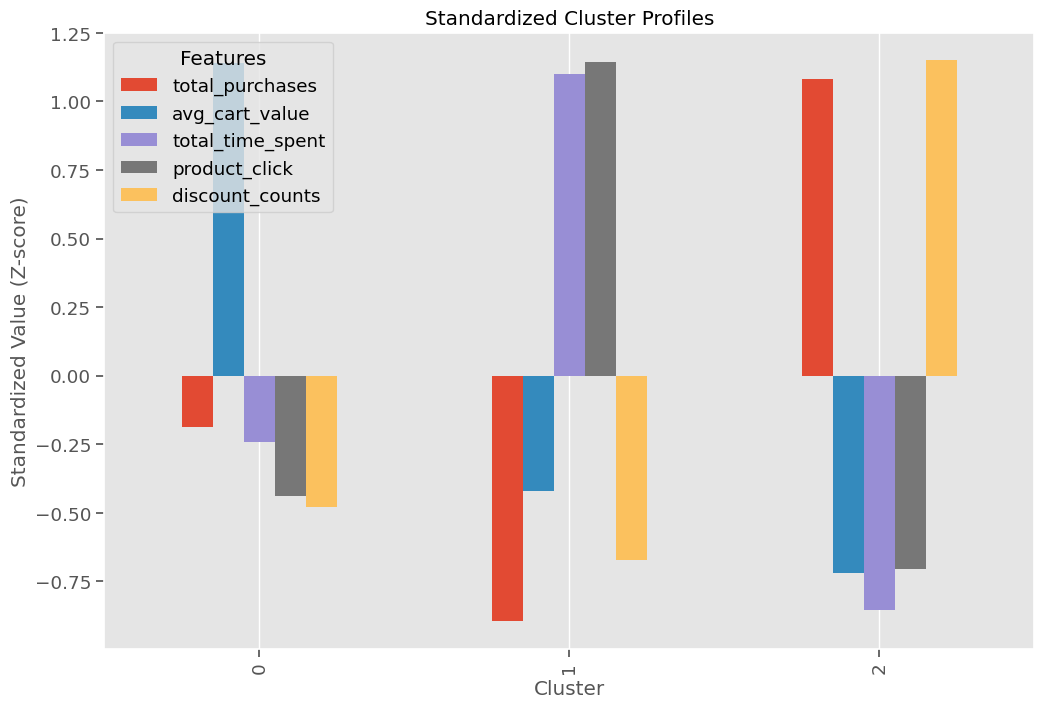

In [21]:
# Visualize the relative differences between clusters
cluster_analysis_std = cluster_analysis.copy()
for col in cluster_analysis.columns:
    cluster_analysis_std[col] = (cluster_analysis[col] - cluster_analysis[col].mean()) / cluster_analysis[col].std()

print("\nStandardized cluster profiles (z-scores):")
print(cluster_analysis_std)

# Visualize cluster profiles
plt.figure(figsize=(14, 7))
cluster_analysis_std.plot(kind='bar')
plt.title('Standardized Cluster Profiles')
plt.xlabel('Cluster')
plt.ylabel('Standardized Value (Z-score)')
plt.grid(axis='y')
plt.legend(title='Features')
plt.savefig(os.path.join(output_dir, "cluster_profiles.png"))
plt.show()
plt.close()

### Mapping Clusters to Business Segments

In [22]:
# Define criteria for mapping based on the problem description
segment_mapping = {}

for cluster_id in range(3):
    profile = cluster_analysis_std.loc[cluster_id]

    # Bargain Hunters: High purchases, Low cart value, High discount usage
    bargain_hunter_score = (profile['total_purchases'] + profile['discount_counts'] - profile['avg_cart_value']) / 3

    # High Spenders: Moderate purchases, High cart value, Low discount usage
    high_spender_score = (profile['avg_cart_value'] - profile['discount_counts']) / 2

    # Window Shoppers: Low purchases, High time spent, High product clicks
    window_shopper_score = (profile['total_time_spent'] + profile['product_click'] - profile['total_purchases']) / 3

    scores = {
        'Bargain Hunters': bargain_hunter_score,
        'High Spenders': high_spender_score,
        'Window Shoppers': window_shopper_score
    }

    # Assign the segment with the highest score
    segment_mapping[cluster_id] = max(scores, key=scores.get)

print("\nCluster to segment mapping:")
for cluster_id, segment in segment_mapping.items():
    print(f"Cluster {cluster_id}: {segment}")

# Segment labels to
df_clean['segment'] = df_clean['cluster'].map(segment_mapping)


Cluster to segment mapping:
Cluster 0: High Spenders
Cluster 1: Window Shoppers
Cluster 2: Bargain Hunters


## Visualization of Customer Segments

###  PCA 2D Visualization


Performing PCA for visualization...


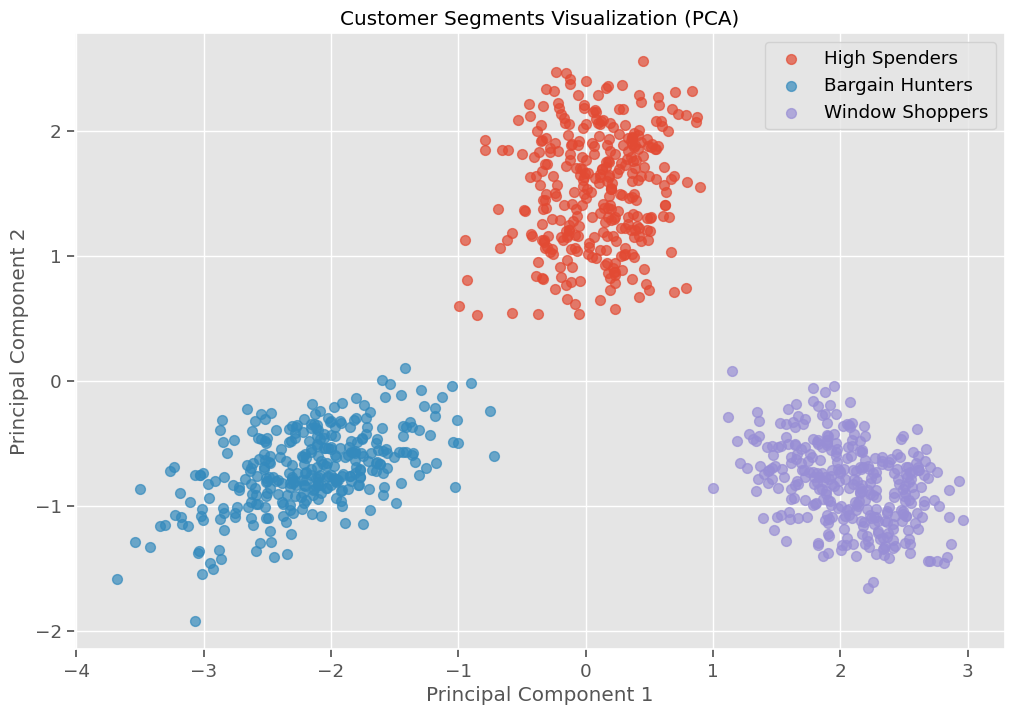

In [23]:
print("\nPerforming PCA for visualization...")
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'], index=df_clean.index)
pca_df['cluster'] = df_clean['cluster']
pca_df['segment'] = df_clean['segment']

plt.figure(figsize=(12, 8))
for segment in pca_df['segment'].unique():
    segment_data = pca_df[pca_df['segment'] == segment]
    plt.scatter(
        segment_data['PC1'],
        segment_data['PC2'],
        label=segment,
        alpha=0.7,
        s=50
    )

plt.title('Customer Segments Visualization (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(output_dir, "pca_visualization.png"))
plt.show()
plt.close()

### PCA 3D Visualization

Performing 3D PCA visualization...


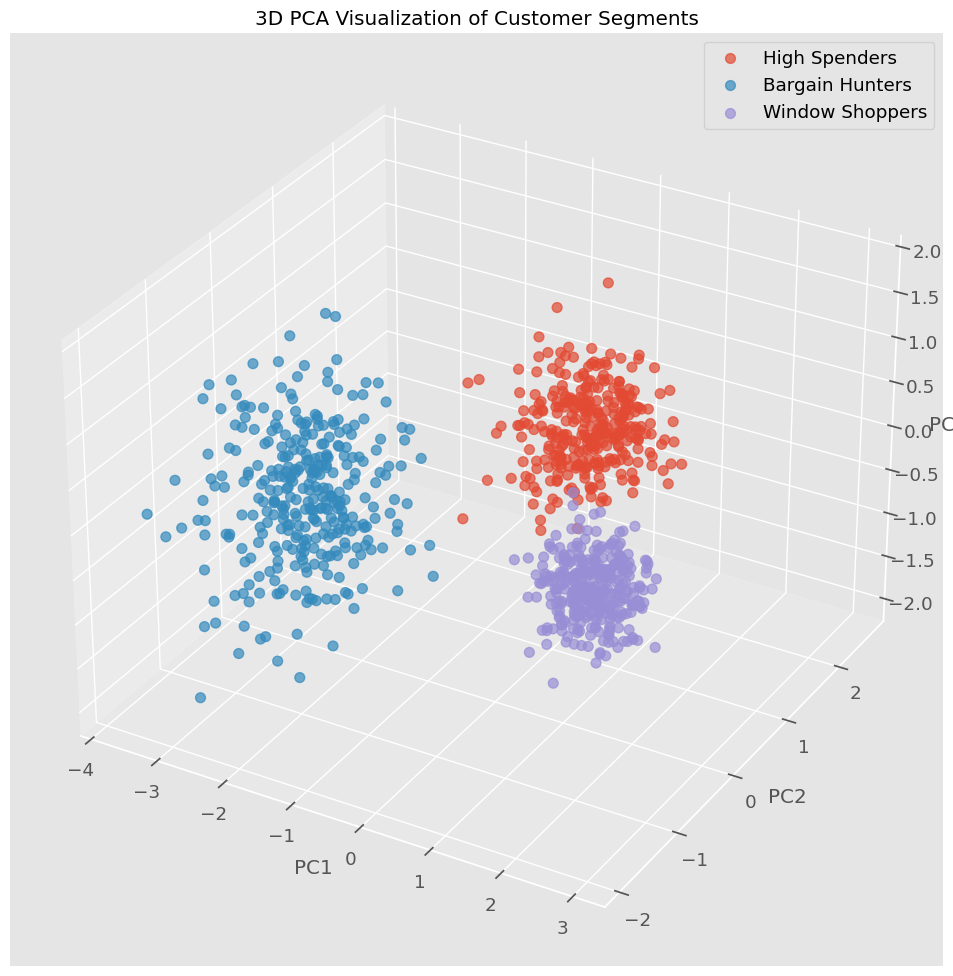

In [24]:
print("Performing 3D PCA visualization...")
pca3d = PCA(n_components=3)
X_pca3d = pca3d.fit_transform(X_scaled)

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Ensure indices match
X_pca3d_df = pd.DataFrame(X_pca3d, index=df_clean.index)

for segment in df_clean['segment'].unique():
    segment_indices = df_clean[df_clean['segment'] == segment].index
    ax.scatter(
        X_pca3d_df.loc[segment_indices, 0],
        X_pca3d_df.loc[segment_indices, 1],
        X_pca3d_df.loc[segment_indices, 2],
        label=segment,
        alpha=0.7,
        s=50
    )

ax.set_title('3D PCA Visualization of Customer Segments')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "pca_3d_visualization.png"))
plt.show()
plt.close()

### t-SNE Visualization

Performing t-SNE visualization...
t-SNE completed in 2.22 seconds


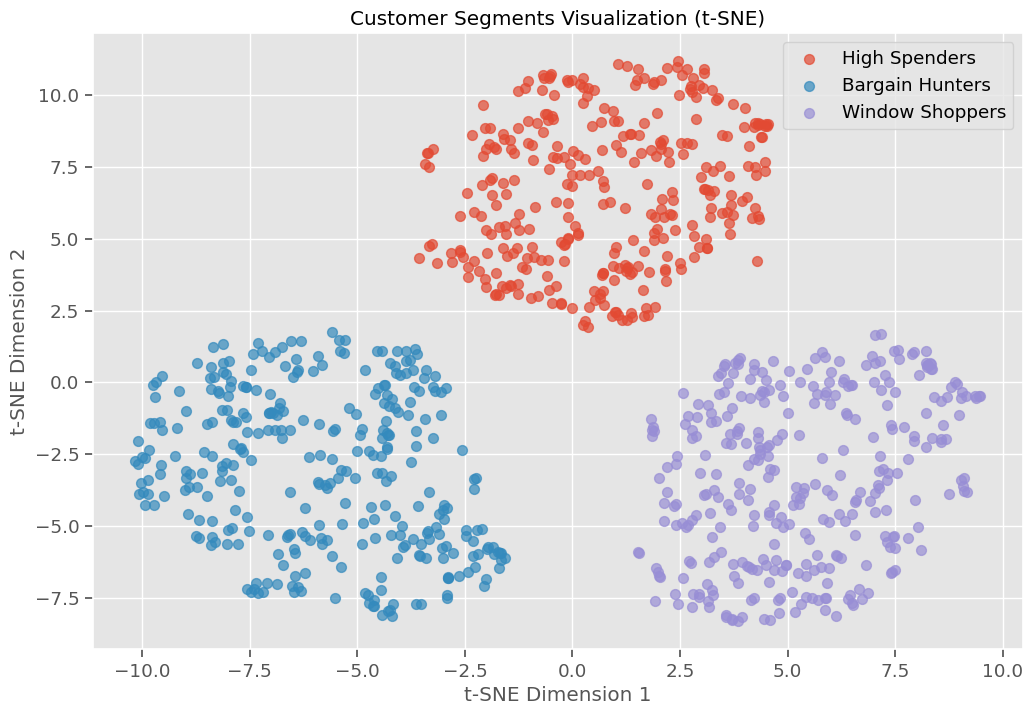

In [25]:
print("Performing t-SNE visualization...")
time_start = time.time()
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)
print(f't-SNE completed in {time.time()-time_start:.2f} seconds')

# Create DataFrame for t-SNE visualization with matching indices
tsne_df = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'], index=df_clean.index)
tsne_df['segment'] = df_clean['segment']

# Plot t-SNE results
plt.figure(figsize=(12, 8))
for segment in tsne_df['segment'].unique():
    segment_data = tsne_df[tsne_df['segment'] == segment]
    plt.scatter(
        segment_data['TSNE1'],
        segment_data['TSNE2'],
        label=segment,
        alpha=0.7,
        s=50
    )

plt.title('Customer Segments Visualization (t-SNE)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(output_dir, "tsne_visualization.png"))
plt.show()
plt.close()

### Radar Chart for Segment Comparison

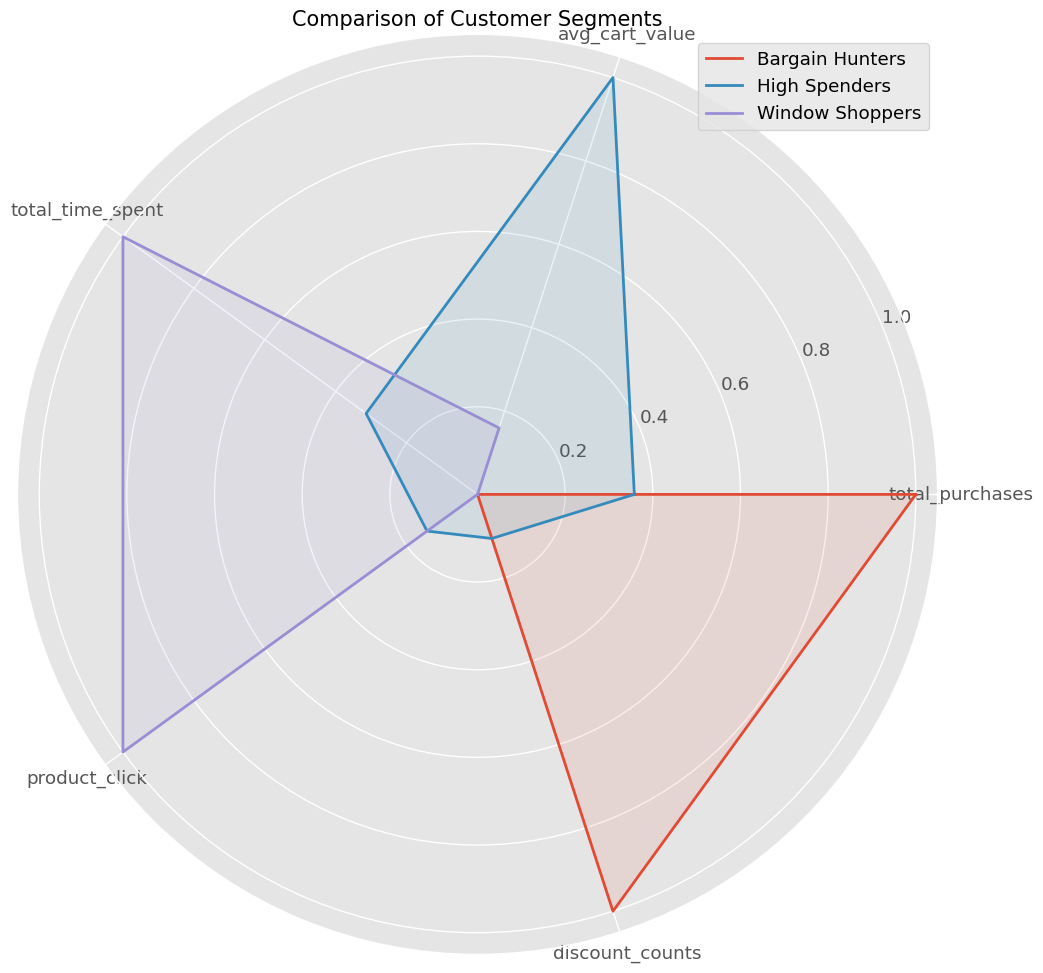

In [26]:
def create_radar_chart(data, segment_names):
    """Create a radar chart comparing the segments."""
    features = data.columns
    num_features = len(features)

    # Angles
    angles = np.linspace(0, 2*np.pi, num_features, endpoint=False).tolist()
    angles += angles[:1]

    # Figure
    fig, ax = plt.subplots(figsize=(12, 10), subplot_kw=dict(polar=True))

    # Segment
    for i, segment in enumerate(segment_names):
        values = data.loc[segment].values.flatten().tolist()
        values += values[:1]

        ax.plot(angles, values, linewidth=2, label=segment)
        ax.fill(angles, values, alpha=0.1)

    # Labels and Title
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(features)
    ax.set_title('Comparison of Customer Segments', size=15)
    ax.legend(loc='upper right')

    plt.tight_layout()
    return fig

# Prepare data
segment_profiles = df_clean.groupby('segment')[feature_cols].mean()

# Scale the data
segment_profiles_scaled = segment_profiles.copy()
for col in segment_profiles.columns:
    min_val = segment_profiles[col].min()
    max_val = segment_profiles[col].max()
    segment_profiles_scaled[col] = (segment_profiles[col] - min_val) / (max_val - min_val)

# Save
radar_fig = create_radar_chart(segment_profiles_scaled, segment_profiles_scaled.index)
radar_fig.savefig(os.path.join(output_dir, "radar_chart.png"))
plt.show()
plt.close(radar_fig)

## Segment Analysis and Statistics

In [27]:
for segment in df_clean['segment'].unique():
    segment_data = df_clean[df_clean['segment'] == segment]
    print(f"\n{segment} Segment:")
    print(f"Number of customers: {len(segment_data)} ({len(segment_data)/len(df_clean)*100:.1f}%)")
    print("\nFeature Statistics:")
    print(segment_data[feature_cols].describe().round(2))


High Spenders Segment:
Number of customers: 325 (33.2%)

Feature Statistics:
       total_purchases  avg_cart_value  total_time_spent  product_click  \
count           325.00          325.00            325.00         325.00   
mean             10.18          147.33             40.28          19.90   
std               3.11           28.41             11.34           4.66   
min               3.00          100.00             20.01           8.00   
25%               8.00          121.79             30.27          17.00   
50%              10.00          148.33             40.22          20.00   
75%              12.00          167.64             50.07          23.00   
max              20.00          199.77             59.88          35.00   

       discount_counts  
count           325.00  
mean              1.97  
std               1.40  
min               0.00  
25%               1.00  
50%               2.00  
75%               3.00  
max               8.00  

Bargain Hunters Segm

### Membership Distribution Analysis


Analyzing segment membership distribution...
                 Cluster_0_Membership  Cluster_1_Membership  \
segment                                                       
Bargain Hunters              0.000008          1.684951e-13   
High Spenders                0.999999          5.405599e-07   
Window Shoppers              0.000001          9.999990e-01   

                 Cluster_2_Membership  
segment                                
Bargain Hunters          9.999925e-01  
High Spenders            5.972251e-08  
Window Shoppers          8.089738e-18  


<Figure size 1200x600 with 0 Axes>

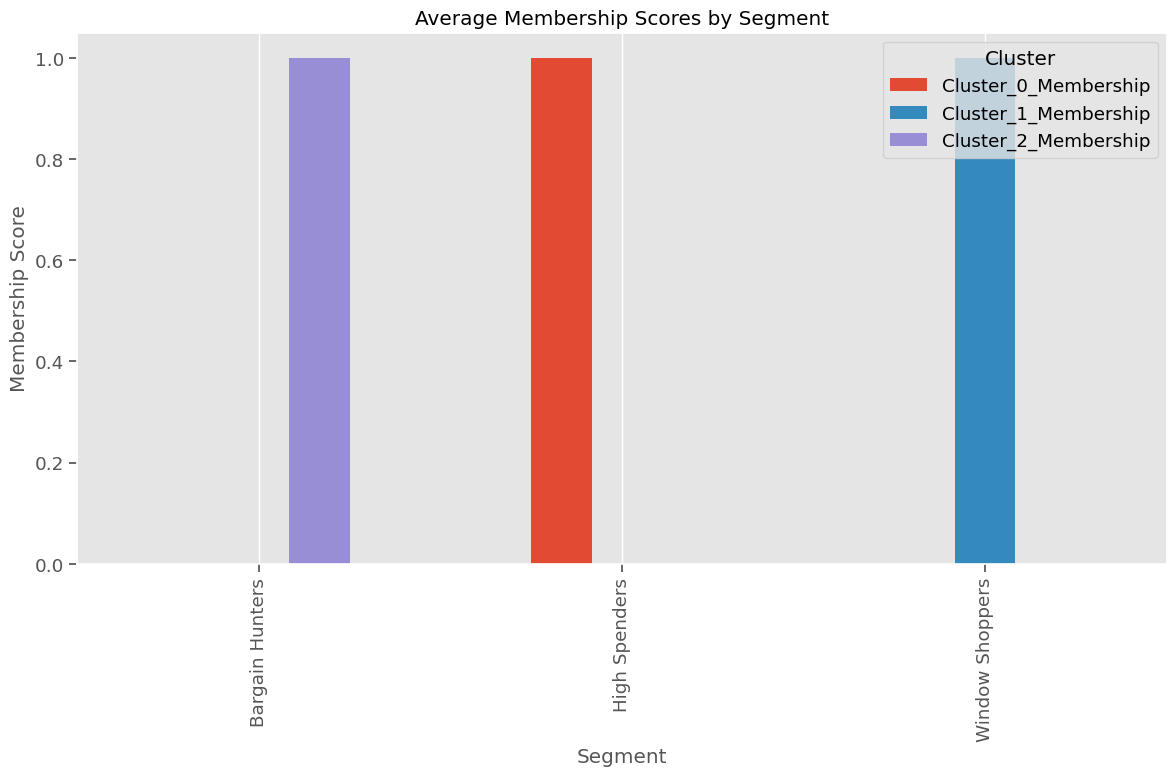

In [28]:
# from soft clustering
print("\nAnalyzing segment membership distribution...")
membership_cols = [col for col in df_clean.columns if 'Membership' in col]
membership_analysis = df_clean.groupby('segment')[membership_cols].mean()
print(membership_analysis)

plt.figure(figsize=(12, 6))
membership_analysis.plot(kind='bar')
plt.title('Average Membership Scores by Segment')
plt.xlabel('Segment')
plt.ylabel('Membership Score')
plt.grid(axis='y')
plt.legend(title='Cluster')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "membership_distribution.png"))
plt.show()
plt.close()

### Mixed Segment Customer Analysis

Identify customers with mixed segment characteristics (high membership in multiple clusters)

In [29]:
threshold = 0.3
multi_segment_customers = df_clean[
    ((df_clean['Cluster_0_Membership'] > threshold) &
     (df_clean['Cluster_1_Membership'] > threshold)) |
    ((df_clean['Cluster_0_Membership'] > threshold) &
     (df_clean['Cluster_2_Membership'] > threshold)) |
    ((df_clean['Cluster_1_Membership'] > threshold) &
     (df_clean['Cluster_2_Membership'] > threshold))
]

print(f"\nNumber of customers with mixed segment characteristics: {len(multi_segment_customers)}")
print(f"Percentage of total customers: {len(multi_segment_customers)/len(df_clean)*100:.1f}%")



Number of customers with mixed segment characteristics: 0
Percentage of total customers: 0.0%


## Business Insights and Marketing Recommendations

Interpreting the clustering results to provide actionable business insights and marketing strategies for each customer segment.

In [30]:
print("\nCustomer Segment Characteristics:")
for segment in df_clean['segment'].unique():
    segment_data = df_clean[df_clean['segment'] == segment]
    mean_values = segment_data[feature_cols].mean()

    print(f"\n{segment}:")
    print(f"  - Total Purchases: {mean_values['total_purchases']:.1f}")
    print(f"  - Average Cart Value: ${mean_values['avg_cart_value']:.2f}")
    print(f"  - Time Spent on Platform: {mean_values['total_time_spent']:.1f} minutes")
    print(f"  - Product Clicks: {mean_values['product_click']:.1f}")
    print(f"  - Discount Usage: {mean_values['discount_counts']:.1f}")



Customer Segment Characteristics:

High Spenders:
  - Total Purchases: 10.2
  - Average Cart Value: $147.33
  - Time Spent on Platform: 40.3 minutes
  - Product Clicks: 19.9
  - Discount Usage: 2.0

Bargain Hunters:
  - Total Purchases: 19.7
  - Average Cart Value: $30.40
  - Time Spent on Platform: 17.5 minutes
  - Product Clicks: 14.9
  - Discount Usage: 9.9

Window Shoppers:
  - Total Purchases: 4.9
  - Average Cart Value: $49.03
  - Time Spent on Platform: 90.1 minutes
  - Product Clicks: 49.7
  - Discount Usage: 1.0


## Results Export and Conclusion

Saving the final dataset with segment labels

In [31]:
output_file = os.path.join(output_dir, "customer_segments_results.csv")
df_clean.to_csv(output_file, index=False)
print(f"\nAnalysis complete. Results saved to '{output_file}'")
print(f"All visualizations saved to '{output_dir}' directory")


Analysis complete. Results saved to 'output/customer_segments_results.csv'
All visualizations saved to 'output' directory
